In [ ]:
import pandas as pd
import numpy as np
from econometron.Models.dynamicsge import linear_dsge
from econometron.Models.StateSpace import SS_Model
from scipy.stats import gamma, beta as beta_dist

In [ ]:
# Model setup
equations=[ 
           "- r_t + phi*p_t=0",
           "p_t - beta * p_tp1 - kappa * (x_t - xbar_t) = 0",
           "x_t - x_tp1 + (1/g) * (r_t - p_tp1) = 0",
           "- xbar_tp1 + rho * xbar_t + sigmax = 0"]
variables=[ 'r','p','x','xbar']
states=['xbar']
exo_states=['xbar']
shock=['sigmax']
# Parameters dictionary
parameters = {
    'g': 5,      # Inverse of relative risk aversion (1/g)
    'beta': 0.99,       # Discount factor
    'kappa': 0,
    'rho': 0.95,        # Persistence of output gap target
    'phi': 1.5,         # Taylor rule inflation coefficient
    'd': 0.5,          # Calvo parameter
    'sigmax':0.01
}

In [ ]:
sigma_X,beta,g,rho,phi,d=parameters['sigmax'],parameters['beta'],parameters['g'],parameters['rho'],parameters['phi'],parameters['d']
parameters['kappa']=((1-d)*(1-d*beta))/d

In [ ]:
new_keynisian_model=linear_dsge(equations=equations,variables=variables,exo_states=exo_states,shocks=shock,parameters=parameters)

In [ ]:
initial_guess = [1, 1, 1]
new_keynisian_model.set_initial_guess(initial_guess)

In [ ]:
new_keynisian_model.compute_ss(initial_guess,method='fsolve',options={'xtol': 1e-10})

Steady-state residuals: [ 0.   -0.    0.   -0.01]


r        0.000000e+00
p        0.000000e+00
x      -4.940656e-324
xbar     0.000000e+00
dtype: float64

In [7]:
A,B,C=new_keynisian_model.approximate(method='analytical')

In [8]:
new_keynisian_model.solve_RE_model()
print("Policy Function (f):\n", new_keynisian_model.f)
print("State Transition (p):\n", new_keynisian_model.p)

Policy Function (f):
 [[-0.64715933]
 [-0.43143956]
 [ 0.94916702]]
State Transition (p):
 [[0.95]]


C:\Users\ASUS\econometron\econometron\Models\dynamicsge\__init__.py:986: UserWarning: Steady state contains zeros so normalize set to False.
  self._compute_irfs(T=T, t0=1, shocks=None, center=True)


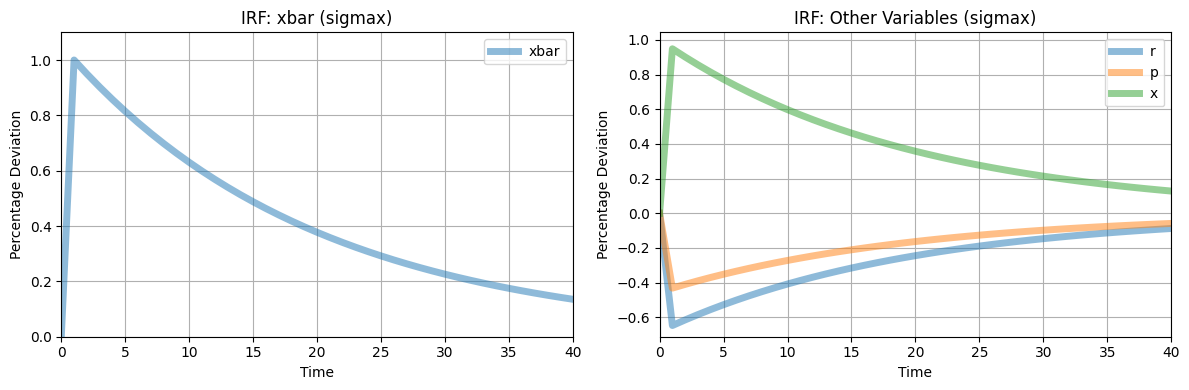

In [9]:
new_keynisian_model.plot_irfs()

In [10]:
new_keynisian_model.simulate(T=100, drop_first=10, covariance_matrix=np.array([[0.01**2]]))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15692\2665661609.py:1: UserWarning: Steady state contains zeros so normalize set to False.
  new_keynisian_model.simulate(T=100, drop_first=10, covariance_matrix=np.array([[0.01**2]]))


,sigmax_t,xbar_t,r_t,p_t,x_t
0,0.002923,0.017110,-0.011073,-0.007382,0.016241
1,0.000338,0.016592,-0.010738,-0.007159,0.015749
2,-0.007869,0.007894,-0.005109,-0.003406,0.007493
3,0.002474,0.009973,-0.006454,-0.004303,0.009466
4,0.010979,0.020454,-0.013237,-0.008824,0.019414
...,...,...,...,...,...
95,-0.008603,-0.010920,0.007067,0.004711,-0.010365
96,0.017918,0.007544,-0.004882,-0.003255,0.007160
97,-0.020795,-0.013629,0.008820,0.005880,-0.012936
98,-0.005358,-0.018306,0.011847,0.007898,-0.017375


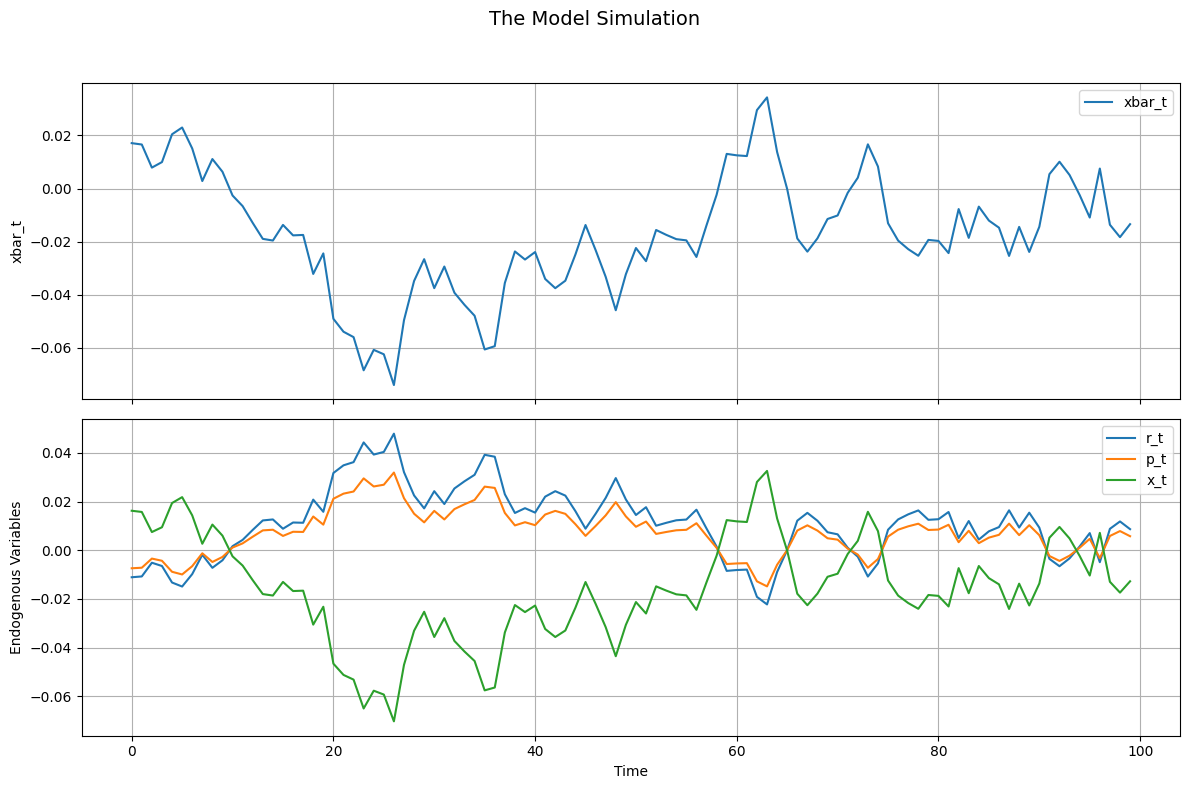

In [11]:
new_keynisian_model.simulations()

In [12]:
GDP=pd.read_csv("../../Data_Fred/gdp.csv", index_col=0, parse_dates=True)
Inflation=pd.read_csv("../../Data_Fred/inflation.csv", index_col=0, parse_dates=True)
Interest_Rate=pd.read_csv("../../Data_Fred/int_rate.csv", index_col=0, parse_dates=True)
mac_data = pd.concat([Interest_Rate, Inflation, GDP], axis=1)
mac_data = mac_data.dropna()
# Rename columns for clarity
mac_data.columns = ['Int', 'Inf', 'GDP']
# Apply log transformation01)
mac_data = np.log(mac_data)
# Remove rows with -inf, inf, or NaN values
mac_data = mac_data.replace([np.inf, -np.inf], np.nan).dropna().transpose()
#int for intrest_rate for simplcity

C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [13]:
if not np.all(mac_data.isna().sum()):
    print("All data is good")

All data is good


In [14]:
mac_data.shape

(3, 138)

In [15]:
from econometron.utils.data_preparation import TransformTS

In [16]:
TSP=TransformTS(mac_data.T,method='hp',lamb=1600)


=== Time Series Analysis ===

Stationarity Check (ADF Test):
Column Int: Non-stationary, p-value: 0.0985, ADF Statistic: -2.5738
Column Inf: Stationary, p-value: 0.0400, ADF Statistic: -2.9484
Column GDP: Non-stationary, p-value: 0.9493, ADF Statistic: -0.1013

Summary Statistics:
                Int           Inf           GDP
count  1.380000e+02  1.380000e+02  1.380000e+02
mean   2.359465e-14  3.829063e-15 -1.308675e-14
std    7.852392e-01  2.761745e-01  1.297678e-02
min   -2.446834e+00 -9.966646e-01 -4.334745e-02
25%   -3.281576e-01 -1.876235e-01 -6.431757e-03
50%    3.864531e-02  2.646428e-02 -6.952629e-04
75%    4.257549e-01  1.810891e-01  8.279967e-03
max    1.418004e+00  6.732762e-01  2.749663e-02

NaN Counts:
Int    0
Inf    0
GDP    0
dtype: int64

Correlation Matrix:
         Int       Inf       GDP
Int  1.00000 -0.163780  0.556330
Inf -0.16378  1.000000  0.225259
GDP  0.55633  0.225259  1.000000


In [17]:
TSP.get_transformed_data().describe()

,Int,Inf,GDP
count,1.380000e+02,1.380000e+02,1.380000e+02
mean,2.359465e-14,3.829063e-15,-1.308675e-14
std,7.852392e-01,2.761745e-01,1.297678e-02
min,-2.446834e+00,-9.966646e-01,-4.334745e-02
25%,-3.281576e-01,-1.876235e-01,-6.431757e-03
50%,3.864531e-02,2.646428e-02,-6.952629e-04
75%,4.257549e-01,1.810891e-01,8.279967e-03
max,1.418004e+00,6.732762e-01,2.749663e-02


In [18]:
trans_data=TSP.get_transformed_data().T.values

<Axes: xlabel='observation_date'>

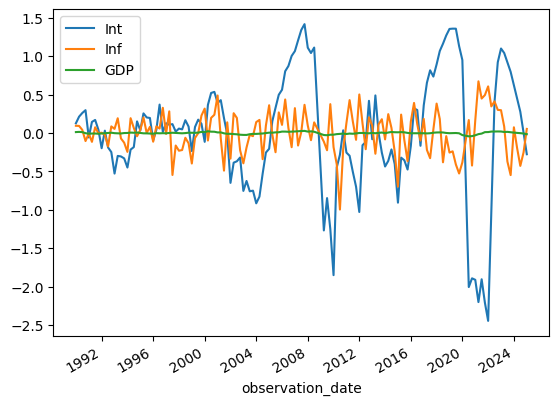

In [19]:
TSP.get_transformed_data().plot()

In [20]:
trans_data.shape

(3, 138)

In [ ]:
Keynes_ss=SS_Model(data=trans_data,parameters=parameters,model=new_keynisian_model,optimizer='SA',estimation_method='Bayesian')
def R_mat(p):
    A1 = np.array([[1, -p ['phi'], 0],
                    [0, 1, -p['kappa']],
                    [1/p ['g'], 0, 1]])

    R1= np.array([[p['sigma_r'], 0, 0],
                [0, p['sigma_p'], 0],
                [0, 0, p['sigma_y']]])
    R=np.linalg.solve(A1,R1)
    return R
def Q_mat(p):
    Q=np.array([[p['sigmax']]])
    return Q
def A_mat(p):
    A=np.array([[p['rho']]])
    return A
def D_mat(p):
    D=np.array([[]])
defined_params=({'kappa':'((1-d)*(1-(d*beta)))/d'})
calibrated_params=[('beta',0.96)]


##########"
Keynes_ss.set_state_cov(Q_mat)
Keynes_ss.set_obs_cov(R_mat)
Keynes_ss.calibrate_params(calibrated_params)
Keynes_ss.define_parameter(defined_params)
update_ss=Keynes_ss._make_state_space_updater()

In [ ]:
LB= [0,0,1,0,0,0,0,0]
UB= [10,1,5,1,1,1,1,1]
priors = {
    'g':       (gamma, {'a': 5, 'scale': 1}),
    'rho':     (beta_dist, {'a': 19, 'b': 1}),
    'phi':     (gamma, {'a': 3, 'scale': 0.5}),
    'd':       (beta_dist, {'a': 10, 'b': 10}),
    'sigmax':  (gamma, {'a': 2, 'scale': 0.02}),
    'sigma_y': (gamma, {'a': 2, 'scale': 0.02}),
    'sigma_p': (gamma, {'a': 2, 'scale': 0.02}),
    'sigma_r': (gamma, {'a': 2, 'scale': 0.02}),
}
sigma=[0.02,0.02, 0.01, 0.01, 0.002, 0.002, 0.002, 0.002]